In [2]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import tensorflow as tf
import numpy as np
import time
from scipy.ndimage import uniform_filter
from sklearn.model_selection import train_test_split

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [34]:
def get_non0_index_scope(l):
    """

    :param l:
    :return:
    """
    if l[0]:
        start = 0
    else:
        start = l.index(True)
    l.reverse()
    if l[0]:
        end = 0
    else:
        end = l.index(True)
    end = len(l) - end
    return start, end


def get_min_content_area(img):
    """

    :param img:
    :return:
    """
    col_proj = (np.sum(img, axis=0) != 0).tolist()
    row_proj = (np.sum(img, axis=1) != 0).tolist()
    col_start, col_end = get_non0_index_scope(col_proj)
    row_start, row_end = get_non0_index_scope(row_proj)

    return row_start, row_end, col_start, col_end


def get_resize_padding_img(img, size=None, padding=None):
    """

    :param img:
    :param size:
    :param padding:
    :return:
    """
    if size and padding:
        sub_img = cv2.resize(img, size)
        sub_img = np.pad(sub_img, padding, mode='constant')
        sub_img = np.pad(sub_img, ((3,), (3,)), mode='constant')
    else:
        sub_img = cv2.resize(img, (28, 28))
    return sub_img

In [35]:
def preprocessing(img):
    row_start, row_end, col_start, col_end = get_min_content_area(img)
    sub_img = img[row_start: row_end, col_start: col_end]
    
    if col_end - col_start < row_end - row_start:  # 铅直边较长
        change_rate = (row_end - row_start - 42) / float((row_end - row_start))
        changed_width = int((col_end - col_start) * (1 - change_rate))

        if changed_width % 2 == 1:
            changed_width += 1
        if changed_width == 0:
            changed_width = 2
        pad = (42 - changed_width) / 2
        padding = ((0,), (int(pad),))

#         print(y1 - y0, x1 - x0, 1 - change_rate, changed_width, pad)
#         plt.imshow(sub_img)
#         plt.show()

        sub_img = get_resize_padding_img(sub_img, size=(changed_width, 42), padding=padding)

    else:  # 水平边较长
        # change_rate = (x1 - x0 - 42) / float((x1 - x0))
        # changed_height = int((y1 - y0) * (1 - change_rate))

        change_rate = (col_end - col_start - 42) / float((col_end - col_start))
        changed_height = int((row_end - row_start) * (1 - change_rate))

        if changed_height % 2 == 1:
            changed_height += 1
        if changed_height == 0:
            changed_height = 2
        pad = (42 - changed_height) / 2
        padding = ((int(pad),), (0,))

#         print(y1 - y0, x1 - x0, 1 - change_rate, changed_height, pad)
#         plt.imshow(sub_img)
#         plt.show()

        sub_img = get_resize_padding_img(sub_img, size=(42, changed_height), padding=padding)

    return sub_img

(<matplotlib.image.AxesImage at 0x28d6499e160>, (2, 90, 58))

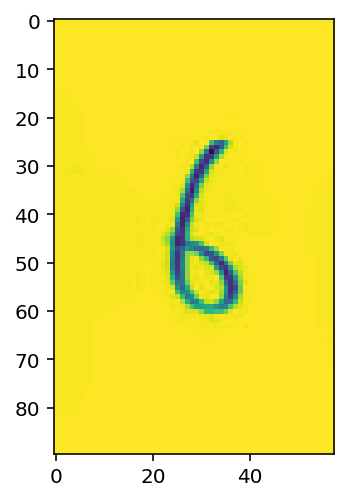

In [107]:
def read_img(file_name, color_inv_norm=True):
    """
    read a image from local file system
    :param file_name:
    :param color_inv_norm:
    :return:
    """
    img = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)

    if color_inv_norm:
        img = 255 - img

        # img = remove_back(img, np.ones((5, 5), np.uint8))

        img = img / 255.0
    else:
        img[img < 50] = 0
        img = img / 255.0

    return img

def get_data(base_path):
    """

    :param base_path:
    :return:
    """
    nums = os.listdir(base_path)
    train_data = []
    train_label = []
    lbl = [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
           [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
           [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
           [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
           [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
           [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
    for num in tqdm(nums):
        calc = 0
        jpgs = os.listdir(os.path.join(base_path, num))
#         print('-' * 30, 'now load %s' % num, '-' * 30)
        for jpg in jpgs:
            # calc += 1
            # if calc > 5000:
            #     print('the %s data is more than 5000' % num)
                # break

            fname = os.path.join(base_path, num, jpg)
            pic = read_img(fname, color_inv_norm=False)
            train_data.append(pic)
            train_label.append(lbl[int(num)])

    train_data = np.array(train_data)
    train_label = np.array(train_label)
    # print(train_data.shape, train_label.shape)
    # print(train_data)
    # print(np.argmax(train_label, axis=1))
    return train_data, train_label



In [160]:
def hog_feature_mul(im):
    """Compute Histogram of Gradient (HOG) feature for an image

         Modified from skimage.feature.hog
         http://pydoc.net/Python/scikits-image/0.4.2/skimage.feature.hog

       Reference:
         Histograms of Oriented Gradients for Human Detection
         Navneet Dalal and Bill Triggs, CVPR 2005

      Parameters:
        im : an input grayscale or rgb image

      Returns:
        feat: Histogram of Gradient (HOG) feature

    """
    # convert rgb to grayscale if needed
#     if im.ndim == 3:
#         image = rgb2gray(im)
#     else:
#         image = np.atleast_2d(im)
    image = im
    _, sx, sy = image.shape  # image size
    orientations = 9  # number of gradient bins
    cx, cy = (8, 8)  # pixels per cell
    gx = np.zeros(image.shape)
    gy = np.zeros(image.shape)
    gx[:, :, :-1] = np.diff(image, n=1, axis=2)  # compute gradient on x-direction
    gy[:, :-1, :] = np.diff(image, n=1, axis=1)  # compute gradient on y-direction
    grad_mag = np.sqrt(gx ** 2 + gy ** 2)  # gradient magnitude
    grad_ori = np.arctan2(gy, (gx + 1e-15)) * (180 / np.pi) + 90  # gradient orientation
    print('grad_ori', grad_ori.shape)
    n_cellsx = int(np.floor(sx / cx))  # number of cells in x
    n_cellsy = int(np.floor(sy / cy))  # number of cells in y
    # compute orientations integral images
    orientation_histogram = np.zeros((image.shape[0], n_cellsx, n_cellsy, orientations))
#     print(orientation_histogram.shape)
    for i in range(orientations):
        # create new integral image for this orientation
        # isolate orientations in this range
        temp_ori = np.where(grad_ori < 180 / orientations * (i + 1),
                            grad_ori, 0)
        temp_ori = np.where(grad_ori >= 180 / orientations * i,
                            temp_ori, 0)
        # select magnitudes for those orientations
        cond2 = temp_ori > 0
        temp_mag = np.where(cond2, grad_mag, 0)
        
        if i == 0:
            print('tmp_mag', uniform_filter(temp_mag, size=(1, cx, cy))[0::1, cx // 2::cx, cy // 2::cy].shape)
        
        # uniform_filter:模糊化
        orientation_histogram[:, :, :, i] = uniform_filter(temp_mag, size=(1, cx, cy))[0::1, cx // 2::cx, cy // 2::cy]
    return orientation_histogram.reshape(orientation_histogram.shape[0], -1)

In [161]:
bins = hog_feature_mul(imgs)
bins.shape

grad_ori (2, 90, 58)
tmp_mag (2, 11, 7)


(2, 693)

---

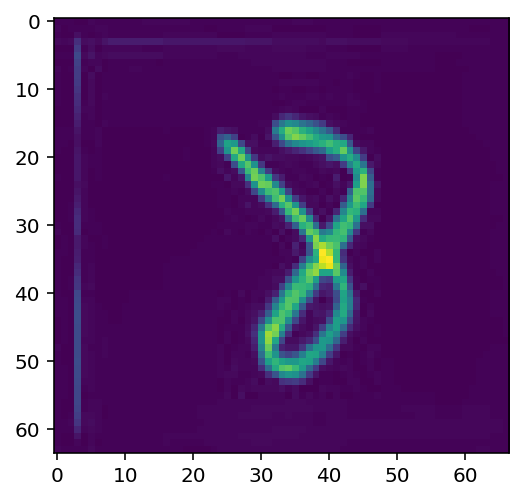

In [26]:
ori = cv2.imread('F:\\dl\\7.jpg', cv2.IMREAD_GRAYSCALE)
img = (255 - ori) / 255.
plt.imshow(img)

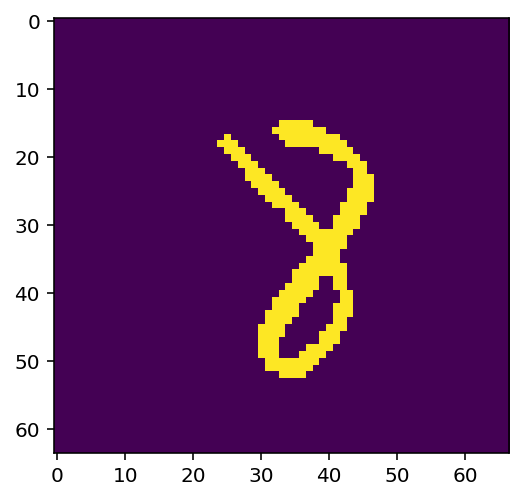

In [30]:
ret, binary = cv2.threshold(ori, 0, 1, cv2.THRESH_OTSU)
binary = 1 - binary
plt.imshow(binary)

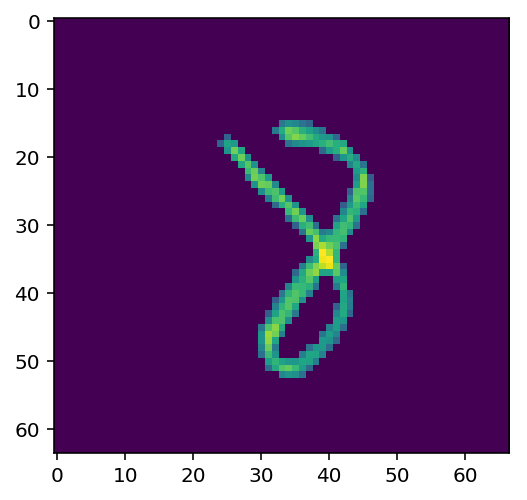

In [32]:
img = img * binary
plt.imshow(img)

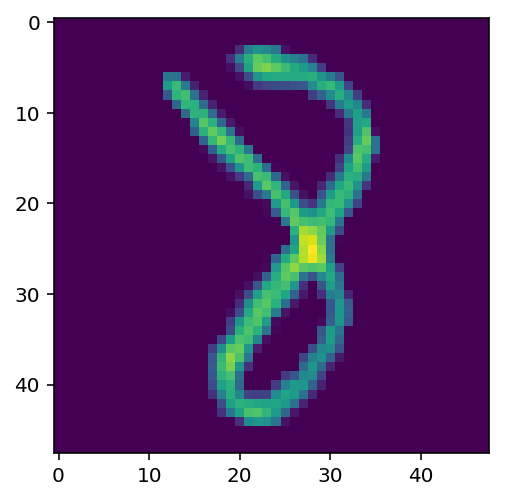

In [36]:
img[img < 0.16] = 0
img = preprocessing(img)
plt.imshow(img)

255


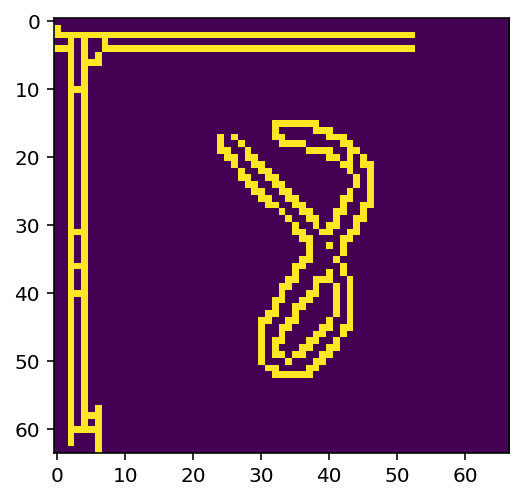

In [63]:
sobel = cv2.Sobel(ori, cv2.CV_8U, dx=1, dy=0, ksize=3)
edges = cv2.Canny(ori,5,100,apertureSize = 3)
print(np.max(edges))
plt.imshow(edges)

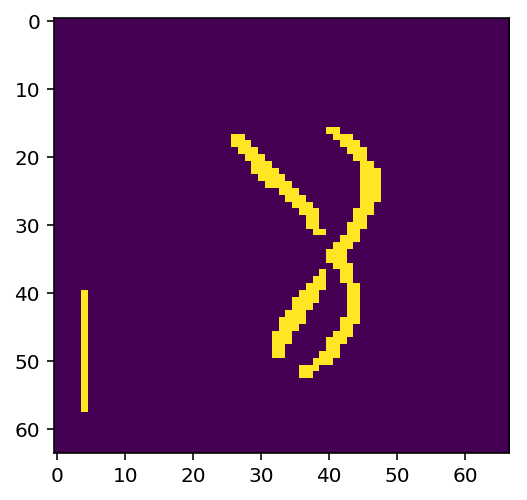

In [56]:
rr, bb = cv2.threshold(sobel, 0, 1, cv2.THRESH_OTSU)
plt.imshow(bb)

In [71]:
lines = cv2.HoughLines(edges, 0.8, np.pi / 180, 10)
for r,theta in lines[0]:

    # Stores the value of cos(theta) in a
    a = np.cos(theta)

    # Stores the value of sin(theta) in b
    b = np.sin(theta)

    # x0 stores the value rcos(theta)
    x0 = a*r

    # y0 stores the value rsin(theta)
    y0 = b*r

    # x1 stores the rounded off value of (rcos(theta)-1000sin(theta))
    x1 = int(x0 + 1000*(-b))

    # y1 stores the rounded off value of (rsin(theta)+1000cos(theta))
    y1 = int(y0 + 1000*(a))

    # x2 stores the rounded off value of (rcos(theta)+1000sin(theta))
    x2 = int(x0 - 1000*(-b))

    # y2 stores the rounded off value of (rsin(theta)-1000cos(theta))
    y2 = int(y0 - 1000*(a))

    # cv2.line draws a line in img from the point(x1,y1) to (x2,y2).
    # (0,0,255) denotes the colour of the line to be 
    #drawn. In this case, it is red. 
    cv2.line(img,(x1,y1), (x2,y2), (255,255,255), 2)

cv2.namedWindow('img', cv2.WINDOW_NORMAL)
cv2.imshow('img', img)
cv2.waitKey(0)
cv2.destroyAllWindows()